In [14]:
import lusid
import lusid.models as models
import os
from msrest.authentication import BasicTokenAuthentication

api_url = os.getenv("FBN_LUSID_API_URL")
api_token = {"access_token": os.environ["ACCESS_TOKEN"]}
credentials = BasicTokenAuthentication(api_token)
client = lusid.LUSIDAPI(credentials, api_url)

In [15]:
import uuid
from datetime import datetime
import pytz
from collections import namedtuple

def build_transaction(trade_spec):
    return models.TransactionRequest(
        transaction_id=str(uuid.uuid4()),
        type="StockIn",
        instrument_uid=trade_spec.id,
        settlement_currency="GBP",
        transaction_date=trade_spec.trade_date,
        settlement_date=trade_spec.trade_date,
        units=100,
        transaction_price=trade_spec.price,
        total_consideration=100 * trade_spec.price,
        source="Client")

scope = "finbourne"
guid = str(uuid.uuid4())
effective_date = datetime(2018, 1, 1, tzinfo=pytz.utc)

request = models.CreateTransactionPortfolioRequest(
    "portfolio-{0}".format(guid),
    "id-{0}".format(guid),
    base_currency="GBP",
    created=effective_date
)

#   create the portfolio
result = client.create_portfolio(scope, request)

assert(result.id.code == request.code)

portfolio_id = result.id.code

TransactionSpec = namedtuple('TransactionSpec', 'id price trade_date')
transaction_specs = [
    TransactionSpec("FIGI_BBG000C6K6G9", 101, effective_date),
    TransactionSpec("FIGI_BBG000C04D57", 102, effective_date),
    TransactionSpec("FIGI_BBG000FV67Q4", 103, effective_date)
]
transaction_specs.sort(key=lambda ts: ts.id)

new_transactions = list(map(build_transaction, transaction_specs))

#   add initial batch of trades
add_transactions_result = client.upsert_transactions(scope, portfolio_id, new_transactions)

In [16]:
try:
    analytic_store = client.get_analytic_store(
        scope,
        effective_date.year,
        effective_date.month,
        effective_date.day
    )
except Exception as e:
    analytic_store_request = models.CreateAnalyticStoreRequest(scope, effective_date)
    client.create_analytic_store(analytic_store_request)

prices = [
    models.InstrumentAnalyticDataDto("FIGI_BBG000C6K6G9", 100),
    models.InstrumentAnalyticDataDto("FIGI_BBG000C04D57", 200),
    models.InstrumentAnalyticDataDto("FIGI_BBG000FV67Q4", 300)
]

#   add prices
prices_result = client.insert_analytics(scope, effective_date.year, effective_date.month, effective_date.day, prices)

In [17]:
aggregation_request = models.AggregationRequest(
    recipe_id=models.ResourceId(scope, "default"),
    metrics=[
        models.AggregateSpec("Holding/default/PV", "Proportion"),
        models.AggregateSpec("Holding/default/PV", "Sum")
    ],
    group_by=["Security/default/CommonName"],
    effective_at=effective_date
)

#   do the aggregation
aggregation = client.get_aggregation_by_portfolio(scope, portfolio_id, aggregation_request)

In [18]:
for item in aggregation.data:
            print("\t{}\t{}\t{}".format(item["Security/default/CommonName"], item["Holding/default/PV%"], item["Holding/default/PV"]))

	BARCLAYS PLC	0.3333333333333333	20000.0
	VODAFONE GROUP PLC	0.16666666666666666	10000.0
	NATIONAL GRID PLC	0.5	30000.0


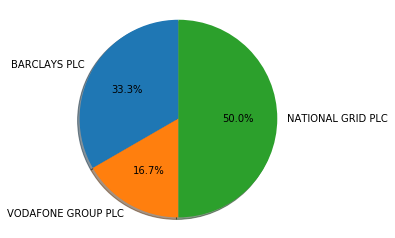

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

labels = []
values = []
for item in aggregation.data:
    labels.append(item["Security/default/CommonName"])
    values.append(item["Holding/default/PV%"] * 100)
    
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()